# Imports

In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch

from tqdm import tqdm
import pickle
from torch import nn
from torch.optim import Adam,RMSprop
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import random
from torchvision import models
from torch.nn import TripletMarginWithDistanceLoss
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import sklearn

# Data Preprocessing Functions

## CRAFT algorithm for  getting bounding boxes around the text part

Source - https://github.com/clovaai/CRAFT-pytorch

In [2]:
from CRAFTpytorchmaster.craft import CRAFT
from CRAFTpytorchmaster import imgproc
from CRAFTpytorchmaster import craft_utils
import torch
from torch.autograd import Variable
from collections import OrderedDict
import numpy as np
import cv2

In [ ]:
def copyStateDict(state_dict):
    '''Utility Function for CRAFT'''
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict


In [ ]:
def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    '''Utility function for craft'''
    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, 1280, interpolation=cv2.INTER_LINEAR, mag_ratio=1.5)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()


    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    
    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)


    return boxes, polys, ret_score_text




In [ ]:
def extract_text_part(path):
    '''Takes image as input and returns cropped image with text'''
    net = CRAFT()
    model_path = r"C:\Users\Shreyas Vaidya\Downloads\craft_mlt_25k.pth"
    net.load_state_dict(copyStateDict(torch.load(model_path, map_location='cpu')))
    net.eval()

    with torch.no_grad():
        img = imgproc.loadImage(path)
        bboxes, _1, _2 = test_net(net, img, 0.7, 0.4, 0.4, cuda = False, poly =False)
        y_min = 30000
        x_min = 30000
        y_max =-1
        x_max = -1
        for i in bboxes:
            for x,y in i:
                y_min = int(min(y,y_min))
                x_min =int( min(x,x_min))
                x_max =int( max(x,x_max))
                y_max =int( max(y,y_max))

    return img[y_min:y_max,x_min:x_max,0]

In [ ]:
#test
plt.imshow(extract_text_part(r"D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\train\M0021\A1.jpg"),cmap = 'gray')

In [ ]:
np.shape(extract_text_part(r"D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\train\M0021\A1.jpg"))

## Otsu algoritm for binarisation of image

In [ ]:
def otsu(image):
    ret2,th2 = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th2

In [ ]:
plt.imshow(otsu(extract_text_part(r"D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\train\M0021\A1.jpg")),cmap = 'gray')

In [ ]:
np.shape(cv2.cvtColor(otsu(extract_text_part(r"D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\train\M0021\A1.jpg")),cv2.COLOR_GRAY2RGB))

## Detecting Language

In [3]:
from tesserocr import PyTessBaseAPI

def langdetect(path):
    images = ['b.jpg']
    images[0] = path
    count = 0
    count2 = 0
    
    with PyTessBaseAPI(path =r"C:\Program Files\Tesseract-OCR\tessdata" ,lang = "hin") as api:
        for img in images:
            api.Init()
            api.SetImageFile(img)
            # print api.AllWordConfidences()
            arr = list(api.AllWordConfidences())
            sumarr = sum(arr) / float(max(len(arr),0.0001))


    with PyTessBaseAPI(path =r"C:\Program Files\Tesseract-OCR\tessdata" ,lang = "eng") as api:
        for img in images:
            api.Init()
            api.SetImageFile(img)
            # print api.AllWordConfidences()
            arr2 = list(api.AllWordConfidences())
            sumarr2 = sum(arr2) / float(max(len(arr2),0.0001))






    n = min(len(arr) , len(arr2))
    for i in range(0 , n):
        if (arr[i] > arr2[i]):
            count += 1
        elif (arr2[i] > arr[i]):
            count2 += 1
        
        else:
            pass



    if (count2 > count):
            lang = "English"
            conf = sumarr2
            api.Init(lang = 'eng')
            api.SetImageFile(images[0])
            return(lang,conf)
    else:
            lang = "Hindi"
            conf = sumarr
            api.Init(lang = 'hin')
            api.SetImageFile(images[0])
            return (lang,conf)


# Creating Dataloader

In [98]:
path = r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\train'
authors = os.listdir(path)

In [ ]:
#PrePRocessing train images
newpath = r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\preprocessedTrain'

for i,author_name in tqdm(enumerate(authors)):
    images = os.listdir(os.path.join(path,author_name))
    label = i
    newimgpath = os.path.join(newpath,str(label))
    os.mkdir(newimgpath)
    os.chdir(newimgpath)
    for j in images:
        try:
            img = otsu(extract_text_part(os.path.join(path,author_name,j)))
            img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            cv2.imwrite(j,img)
        except:
            pass
     
        


In [ ]:
oldvalpath = "D:/Shreyas/Shreyas_study/vision_Challenges/dataset/dataset/val"
newvalpath = r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\preprocessedVal'
os.mkdir(newvalpath)
fail_count = 0
for i in tqdm(os.listdir(oldvalpath)):
        try:
                img = otsu(extract_text_part(os.path.join(oldvalpath,i)))
                img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

        except:
                img = otsu(cv2.imread(os.path.join(oldvalpath,i),cv2.IMREAD_GRAYSCALE))
                img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

        cv2.imwrite(os.path.join(newvalpath,i),img)
    
         


In [4]:
path = r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\preprocessedTrain'
authors = os.listdir(path)

In [5]:
same_pairs_list = []# List with 2 authors from same class and class label,will be used as anchor and positive
for i,author_name in tqdm(enumerate(authors)):
    images = os.listdir(os.path.join(path,author_name))
    
    label = i
    for j in range(0,len(images)-1):
        list_to_append = [os.path.join(path,author_name,images[j]),os.path.join(path,author_name,images[j+1]),label]
        if(langdetect(os.path.join(path,author_name,images[j]))[0]!="Hindi" or langdetect(os.path.join(path,author_name,images[j]))[1]<=1e-2 or langdetect(os.path.join(path,author_name,images[j+1]))[0]!="Hindi" or langdetect(os.path.join(path,author_name,images[j+1]))[1]<=1e-2):
            for i in range(10):
                same_pairs_list.append(list_to_append)
        else:
            same_pairs_list.append(list_to_append)
    try:
        if(langdetect(os.path.join(path,author_name,images[-2]))[0]!="Hindi" or langdetect(os.path.join(path,author_name,images[-2]))[1]<=1e-2 or langdetect(os.path.join(path,author_name,images[-1]))[0]!="Hindi" or langdetect(os.path.join(path,author_name,images[-1]))[1]<=1e-2):
            for i in range(10):
                same_pairs_list.append([os.path.join(path,author_name,images[-2]),os.path.join(path,author_name,images[-1]),label])
        else:
            same_pairs_list.append([os.path.join(path,author_name,images[-2]),os.path.join(path,author_name,images[-1]),label])

    except:
        pass  



1352it [1:43:02,  4.57s/it]


In [7]:

same_pairs_list[0]

['D:\\Shreyas\\Shreyas_study\\vision_Challenges\\dataset\\dataset\\preprocessedTrain\\0\\A0.jpg',
 'D:\\Shreyas\\Shreyas_study\\vision_Challenges\\dataset\\dataset\\preprocessedTrain\\0\\A1.jpg',
 0]

In [3]:
len(same_pairs_list)

68233

In [8]:
import pickle 
with open ("same_pairs_list.pickle","wb") as file:
    pickle.dump(same_pairs_list,file)

In [2]:
import pickle 
with open ("same_pairs_list.pickle","rb") as file:
    same_pairs_list = pickle.load(file)

In [16]:
images_list = [] #will be used for the negative in triplet loss
for i,author_name in tqdm(enumerate(authors)):
    images = os.listdir(os.path.join(path,author_name))
    random.shuffle(images)
    label = i
    for j in images:
        path_to_append = os.path.join(path,author_name,j)
        if langdetect(path_to_append)[0]!="Hindi" or langdetect(path_to_append)[1]<=1e-2:
            for _ in range(10):
                images_list.append([path_to_append,label])
        else:
            images_list.append([path_to_append,label])
            


1352it [1:05:30,  2.91s/it]


In [18]:
import pickle 
with open ("images_list.pickle","wb") as file:
    pickle.dump(images_list,file)

In [4]:
import pickle 
with open ("images_list.pickle","rb") as file:
    images_list = pickle.load(file)

In [5]:
len(images_list)

47112

In [105]:
#creating list of image pairs with combinations and labels of 1 or 0

imgp_label_list = []

count = 0
authors = os.listdir(path)
for i,author_name in tqdm(enumerate(authors)):
  other_list = authors[i:i+2] if i<len(authors)-1 else authors[i:]
  for author_name2 in other_list:
    label = 1 if author_name == author_name2 else 0
    if(label==1):
      ilist = os.listdir(os.path.join(path,author_name))
      lent = len(ilist)
      for i in range(lent):
        for j in range(i+1,lent):#so that no collisions
          img1,img2 = ilist[i],ilist[j]
          
          imgp_label_list.append([os.path.join(path,author_name,img1),os.path.join(path,author_name2,img2),label])
    else:
      for img1 in os.listdir(os.path.join(path,author_name)):
        for img2 in os.listdir(os.path.join(path,author_name2)):
          if(author_name != author_name2 or img1 !=img2):

            
            imgp_label_list.append([os.path.join(path,author_name,img1),os.path.join(path,author_name2,img2),label])
          

1352it [00:01, 791.08it/s]


In [106]:
len(imgp_label_list)

104767

In [6]:
class mDataset(Dataset):
  def __init__(self,array,transform ):
    self.array =array
    self.transform = transform
    
  def __getitem__(self,index):
    
    
        indexlist = self.array[index]
        img0 = Image.open(indexlist[0])
        
        #img0 = img0.convert("L")
        img0 = self.transform(img0)
        label = indexlist[-1]
        
        if(len(indexlist)==3):
          img1 = Image.open(indexlist[1])
          #img1 = img1.convert("L")

          img1 = self.transform(img1)
          return img0,img1,label
        else:
          return img0,label
    

    
    
  def __len__(self):
    return len(self.array)

In [7]:
class SiamesepairwiseDataset(Dataset):
  def __init__(self,array,path= None,transform = None):
    self.array =array
    self.transform = transform
    self.path = path
    
  def __getitem__(self,index):
    
    indexlist = self.array[index]
        
    if self.path is None:
      img0 = Image.open(indexlist[0])
      #img0 = img0.convert("L")

      img1 = Image.open(indexlist[1])
      #img1 = img1.convert("L")


      
    else:
      img0 = Image.open(os.path.join(self.path,indexlist[0]))
      #img0 = img0.convert("L")

      img1 = Image.open(os.path.join(self.path,indexlist[1]))
      #img1 = img1.convert("L")

    
    label = indexlist[2]
    
    if self.transform is not None:
        
      img0 = self.transform(img0)
      img1 = self.transform(img1)
    


      
      
    return img0,img1,label
    
  def __len__(self):
    return len(self.array)

In [10]:
mytraintransform = transforms.Compose([transforms.Resize((256,256)),transforms.RandomResizedCrop(224) ,transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])]
                               )
myvaltransform = transforms.Compose([transforms.Resize((256,256)),transforms.CenterCrop(224) ,transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])]
                               )

to_tensor = transforms.Compose([transforms.ToTensor(),
                               ])

In [11]:
random.shuffle(same_pairs_list)


anchor_p_dataset = mDataset(same_pairs_list,transform= mytraintransform)
random.shuffle(images_list)
n_dataset = mDataset(images_list,transform=mytraintransform)


In [12]:
trainp_dataloader = DataLoader(anchor_p_dataset,batch_size=100)
trainn_dataloader = DataLoader(n_dataset,batch_size=100)

In [15]:
df = pd.read_csv(r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\val.csv')

df

,img1_name,img2_name,label
0,70a4ba9a.jpg,58f68a00.jpg,1
1,e15b612e.jpg,16ce5df2.jpg,0
2,6c64d988.jpg,735d3636.jpg,1
3,b74681a6.jpg,cb50496d.jpg,0
4,c97aa428.jpg,6f9dc747.jpg,1
...,...,...,...
5765,4e7762f7.jpg,2f3d2bce.jpg,0
5766,c1c49f87.jpg,1072597f.jpg,0
5767,03e66099.jpg,f877b1b6.jpg,1
5768,8e056e51.jpg,f68e79a1.jpg,1


In [16]:
val_dataset = SiamesepairwiseDataset(np.array(df),path = r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\preprocessedVal',transform=myvaltransform)

In [17]:
val_dataloader = DataLoader(val_dataset)

In [150]:
import torchvision
classification_models = models.list_models(module=models)


In [139]:
len(classification_models)

80

# Defining the model

In [18]:
pretrainednet = models.resnet50(weights="DEFAULT")

pretrainednet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:

pretrainednet.tail = nn.Sequential(nn.ReLU(inplace=True),nn.Linear(in_features=1000,out_features=128))

In [20]:
#create a siamese network
class SiameseresNetwork(nn.Module):
    def __init__(self):
        super(SiameseresNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.clf = pretrainednet
        
    def forward_once(self, x):
        # Forward pass 
        output = self.clf(x)
        return output

    def forward(self, input1, input2,input3 = None):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        if(input3 is not None):
            output3 = self.forward_once(input3)
            return output1, output2,output3
        return output1, output2


In [21]:
net = SiameseresNetwork()
pretrainednet.load_state_dict(torch.load("pret.pth"))
net.load_state_dict(torch.load("net.pth"))
optimizer =Adam(net.parameters())
optimizer.load_state_dict(torch.load("optim.pt"))

In [22]:
# Declare Siamese Network
n_epochs = 1


# Decalre Loss Function
criterion = TripletMarginWithDistanceLoss(distance_function= lambda t1,t2: 1-torch.cosine_similarity(t1,t2) )
# Declare Optimizer
#train the model
loss=[] 
counter=[]
test_loss = []
#for training of knn
train_im1 = []
train_im0  = []

def train():
    
    net.train()
    for data1,data2 in  zip(trainp_dataloader,trainn_dataloader):
        
        for adata,pdata,l1 in tqdm(zip(data1[0],data1[1],data1[2])):
            for  ndata,l2 in zip(data2[0],data2[1]):
                
                if(l1!=l2):
                        
                        
                        output1,output2,output3 = net(adata[None,:],pdata[None,:],ndata[None,:])#Adding extra dimension
                        optimizer.zero_grad()
                        
                        loss_contrastive = criterion(output1,output2,output3)
                        
                        
                        if(math.isnan(loss_contrastive.item())):
                            print("Nan")
                            break
                        if(loss_contrastive.item()>0):
                            loss_contrastive.backward()
     
                            optimizer.step()
                        
                         
                        train_im1.append([adata,pdata,1])
                        train_im0.append([adata,ndata,0])
                        
                        # else:
                        
                            
                            
                        #     trainX.append(1-torch.cosine_similarity(output1,output2).item())
                        #     trainy.append(1)
                        #     trainX.append(1-torch.cosine_similarity(output1,output3).item())
                        #     trainy.append(0)
                
                            
               
        

        test()
        net.train()
            
  
      
         
           
                        



    
def test():
    net.eval()
    with torch.no_grad():
        
        testX = np.zeros(5770)
        y_true = np.zeros(5770)
        for count,i in tqdm(enumerate(val_dataloader),position=0,leave=True):
            img0,img1,label = i
            output1,output2= net(img0,img1)
            testX[count] = 1-torch.cosine_similarity(output1,output2).item()
            y_true[count] = label
       

        batch_size = 512
        counter = 0
        nextbreak = False
        
        trainX  = np.zeros(5770*2)
        trainy =  np.zeros(5770*2)
        random.shuffle(train_im0)
        random.shuffle(train_im1)
        tdataloader = DataLoader(train_im1,batch_size=512)
        for i in tqdm(tdataloader):
            if(nextbreak):
                break
            img0,img1,label = i
            
      #img0,img1 = img0.cuda(),img1.cuda()
      
            output1,output2 = net(img0,img1)
            dist = 1- torch.cosine_similarity(output1,output2)
      
            if(counter+batch_size-1<5770):
                trainX[counter:counter+batch_size] = dist.cpu()
                trainy[counter:counter+batch_size] =  label
                counter+=batch_size
            else:
                trainX[counter:5770] = dist.cpu()[:5770-counter]
                trainy[counter:5770] = label[:5770-counter]
                nextbreak = True
      
        counter = 5770
        nextbreak = False
        
        
        tdataloader = DataLoader(train_im0,batch_size=512)
        for i in tqdm(tdataloader):
            if(nextbreak):
                break
            img0,img1,label = i
            
      #img0,img1 = img0.cuda(),img1.cuda()
      
            output1,output2 = net(img0,img1)
            dist = 1- torch.cosine_similarity(output1,output2)
      
            if(counter+batch_size-1<5770*2):
                trainX[counter:counter+batch_size] = dist.cpu()
                trainy[counter:counter+batch_size] =  label
                counter+=batch_size
            else:
                trainX[counter:] = dist.cpu()[:5770*2-counter]
                trainy[counter:] = label[:5770*2-counter]
                nextbreak = True


        
        
        trainX = trainX.reshape(-1,1)
        testX = testX.reshape(-1,1)
        torch.save(pretrainednet.state_dict(),"pret.pth")
        torch.save(net.state_dict(),"net.pth")
        knn = KNeighborsClassifier(metric="cosine")
        knn.fit(trainX,trainy)
        y_pred = knn.predict(testX)
        y_prob = knn.predict_proba(testX).T[1].reshape(-1)
        
        print("Train Accuracy",knn.score(trainX,trainy))
        print("val F1",f1_score(y_true,y_pred))
        print("val AUC",roc_auc_score(y_true,y_prob))
        with open("gooddprayswaminarayan.pickle","wb") as file:
            pickle.dump([trainX,trainy,testX,y_true,y_pred,y_prob],file)

        

        
        
    



        
#set the device to cuda

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train()


100it [2:27:38, 88.59s/it]
5770it [24:05,  3.99it/s]
 60%|██████    | 12/20 [16:27<10:58, 82.26s/it]


Train Accuracy 0.5
val F1 0.0
val AUC 0.5


100it [2:25:51, 87.52s/it]
5770it [24:31,  3.92it/s]
 30%|███       | 12/40 [16:30<38:30, 82.52s/it]


Train Accuracy 0.5
val F1 0.0
val AUC 0.5


100it [2:20:18, 84.18s/it]
5770it [24:00,  4.00it/s]
 20%|██        | 12/59 [16:40<1:05:18, 83.37s/it]


Train Accuracy 0.5
val F1 0.0
val AUC 0.5


100it [2:30:25, 90.25s/it]
5770it [25:07,  3.83it/s]
 15%|█▌        | 12/79 [16:59<1:34:49, 84.92s/it]


Train Accuracy 0.5086655112651647
val F1 0.32107496463932106
val AUC 0.5008665511265165


100it [2:18:16, 82.97s/it]
5770it [25:09,  3.82it/s]
 12%|█▏        | 12/98 [17:55<2:08:29, 89.65s/it]


Train Accuracy 0.5
val F1 0.0
val AUC 0.5027729636048527


100it [2:30:20, 90.21s/it]
5770it [24:16,  3.96it/s]
 10%|█         | 12/118 [17:06<2:31:09, 85.57s/it]


Train Accuracy 0.5
val F1 0.0
val AUC 0.5


100it [2:42:38, 97.59s/it] 
5770it [25:48,  3.73it/s]
  9%|▉         | 12/137 [18:08<3:08:59, 90.71s/it]


Train Accuracy 0.5
val F1 0.0
val AUC 0.5


100it [2:25:09, 87.09s/it]
5770it [24:17,  3.96it/s]
  8%|▊         | 12/157 [17:41<3:33:40, 88.42s/it]


Train Accuracy 0.5
val F1 0.0
val AUC 0.5


100it [2:30:18, 90.18s/it]
5770it [24:17,  3.96it/s]
  7%|▋         | 12/176 [17:50<4:03:53, 89.23s/it]


Train Accuracy 0.5
val F1 0.0
val AUC 0.5


70it [1:44:58, 89.98s/it]


KeyboardInterrupt: 

In [23]:
torch.save(pretrainednet.state_dict(),"pret.pth")
torch.save(net.state_dict(),"net.pth")
torch.save(optimizer.state_dict(),"optim.pt")
with open ("reversedimagelist.pickle",'wb') as file:
    pickle.dump(images_list,file)
with open ("reversedsamepaires.pickle",'wb') as file:
    pickle.dump(same_pairs_list,file)

# Testing

In [111]:
val_dataloader = DataLoader(val_dataset,batch_size = 512)

In [52]:
l = []
l.append(torch.Tensor([[1],2,3])[None,:])
l.append(torch.Tensor([1,2,3])[None,:])
l.append(torch.Tensor([1,2,3])[None,:])
d = DataLoader(l,batch_size=2)
for i in d,


0it [00:00, ?it/s]


In [53]:
train_im

[]

In [128]:
testX = np.zeros(5770)
testy = np.zeros(5770)
with torch.no_grad():
  sumdist = 0
  counter = 0
  batch_size = 512

  for i in tqdm(val_dataloader):
      
      img0,img1,label = i
      
      #img0,img1 = img0.cuda(),img1.cuda()
      
      output1,output2 = net(img0,img1)
      dist = 1-torch.cosine_similarity(output1,output2)
      
      if(counter+batch_size-1<5770):
        testX[counter:counter+batch_size] = dist.cpu()
        testy[counter:counter+batch_size]  = label
        counter+=batch_size
      else:
        testX[counter:] = dist.cpu()
        testy[counter:] = label

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [17:31<00:00, 87.65s/it]


In [116]:
torch.save(net.state_dict(),"good.pth")
torch.save(pretrainednet.state_dict(),"gres.pth")

In [ ]:
len(imgp_label_list)

In [ ]:
net = SiameseNetwork()

In [ ]:
vgg.load_state_dict(torch.load("vgg.pt"))
net.load_state_dict(torch.load("modelpls.pt"))

In [126]:
trainpdataloader = DataLoader(SiamesepairwiseDataset(imgp_label_list,transform=mytransform),batch_size = 512)

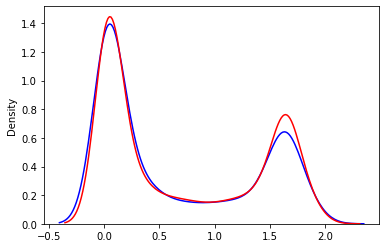

In [131]:
sns.kdeplot(trainX[trainy==1],color = "blue")
sns.kdeplot(trainX[trainy==0],color = "red")
plt.show()

In [135]:
knn = KNeighborsClassifier(metric="cosine")
knn.fit(trainX.reshape(-1,1),trainy)

KNeighborsClassifier(metric='cosine')

In [141]:
roc_auc_score(testy,knn.predict_proba(testX.reshape(-1,1)).T[0])



0.5015597920277297

In [ ]:
import pickle
with open ("d.pickle",'rb') as file:
    [X,y] = pickle.load(file)

In [ ]:
sns.kdeplot(X[y==0],color='red')
sns.kdeplot(X[y==1],color='blue')
plt.show()

In [ ]:
knn = KNeighborsClassifier(metric="cosine",n_neighbors=5)
knn.fit(X.reshape(-1,1),y)

In [142]:
import pickle
with open('testdgood.pickle','wb') as file:
    pickle.dump([testX,testy],file)

In [ ]:
with torch.no_grad():
    testX = np.zeros(5770)
    y_true = np.zeros(5770)
    for count,i in tqdm(enumerate(val_dataloader),position=0,leave=True):
        img0,img1,label = i
        output1,output2= net(img0,img1)
        testX[count] = 1-torch.cosine_similarity(output1,output2).item()
            
        y_true[count] = label
    testX = testX.reshape(-1,1)


In [ ]:
f = []
auc = []
for i in tqdm(range(1,16)):
    knn = KNeighborsClassifier(metric="cosine",n_neighbors=i)
    knn.fit(X.reshape(-1,1),y)
    y_pred = knn.predict(testX)
    y_prob =knn.predict_proba(testX).T[1].reshape(-1)

    f.append(f1_score(y_true,y_pred))
    auc.append(roc_auc_score(y_true,y_prob))



In [ ]:
plt.plot(range(15),f)

In [ ]:
_,cdfprobabilities1 = sns.ecdfplot(distances1).get_lines()[0].get_data()


In [ ]:
sns.ecdfplot(distances1,color = 'blue')
sns.ecdfplot(distances0,color = 'red')
plt.show()

In [ ]:
d0,probabilities0 = sns.kdeplot(distances0).get_lines()[0].get_data()

In [ ]:
d1,probabilities1 = sns.kdeplot(distances1).get_lines()[0].get_data()

In [ ]:
def get_nearest_index(test_distance,array ):
    array = np.asarray(array)
    
    return (np.abs(array-test_distance)).argmin() 

In [ ]:
def get_label_and_probability(test_distance ):
  idx1 = get_nearest_index(test_distance,d1)
  idx0 = get_nearest_index(test_distance,d0)
  cdfidx1 = get_nearest_index(test_distance,distances1)
  prob0 = probabilities0[idx0]
  prob1 = probabilities1[idx1]
  label = 1 if prob1>= prob0 else 0
  probans = cdfprobabilities1[1:][cdfidx1]
  
  
  
  return label,probans

In [ ]:
transform=transforms.Compose([transforms.Resize((250,25)),
                                                              transforms.ToTensor()
                                                                      ])

In [ ]:
val_dataset = SiamesepairwiseDataset(np.array(df),path = r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\val',transform=mytransform)

In [ ]:
val_dataloader = DataLoader(val_dataset)

In [ ]:
with torch.no_grad():
  
  y_pred = np.zeros(5770)
  y_prob  = np.zeros(5770)

  for count,i in tqdm(enumerate(val_dataloader)):
    img0,img1,_ = i
    #img0,img1 = img0.cuda(),img1.cuda()
    output1,output2 = net(img0,img1)
    dist = 1-torch.cosine_similarity(output1,output2)
    (label,prob) = get_label_and_probability(dist.item())
    
    y_pred[count] = label
    y_prob[count] = prob
    

In [ ]:
y_true = df['label'].values

In [ ]:
f1_score(y_true,y_pred)

In [ ]:
roc_auc_score(y_true,y_prob)